In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
from keras import layers,losses
from keras.models import Model


In [ ]:
dataframe=pd.read_csv("/content/drive/MyDrive/ecg.csv")
raw_data=dataframe.values

# The last element contains the labels
labels= raw_data[:, -1]

#The other data points are the ecg data
data =raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels=train_test_split(data,labels,test_size=0.2, random_state=21)

min_val=tf.reduce_min(train_data)
max_val=tf.reduce_max(train_data)

train_data=(train_data-min_val)/(max_val-min_val)
test_data=(test_data-min_val)/(max_val-min_val)

train_data=tf.cast(train_data,tf.float32)
test_data=tf.cast(test_data, tf.float32)

train_labels=train_labels.astype(bool)
test_labels=test_labels.astype(bool)

normal_train_data=train_data[train_labels]
normal_test_data=test_data[test_labels]

anomalous_train_data=train_data[~train_labels]
anomalous_test_data=test_data[~test_labels]

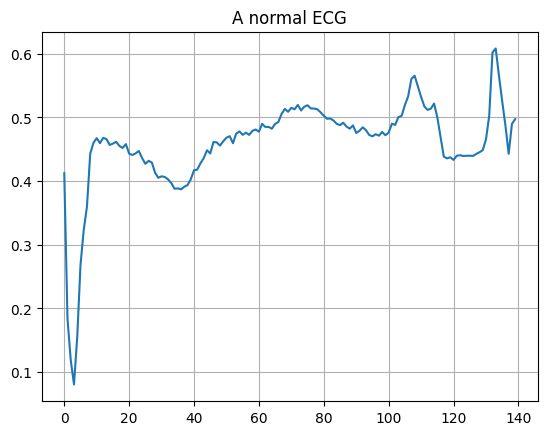

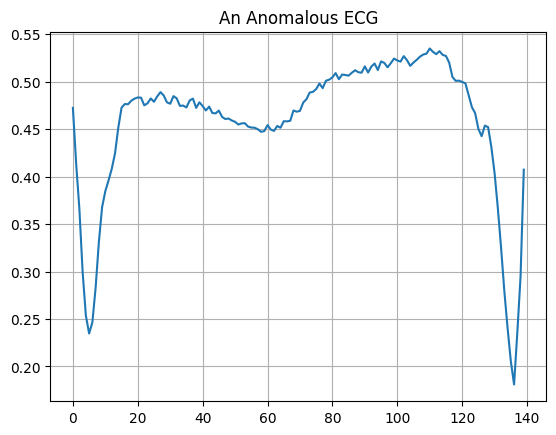

In [ ]:
#plotting normal ECG
plt.grid()
plt.plot(np.arange(140),normal_train_data[2])
plt.title("A normal ECG")
plt.show()

#plotting anomalous
plt.grid()
plt.plot(np.arange(140),anomalous_train_data[2])
plt.title("An Anomalous ECG")
plt.show()

In [ ]:

class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector,self).__init__()
        self.encoder=tf.keras.Sequential([
            layers.Dense(32, activation="relu"),
            layers.Dense(16, activation="relu"),
            layers.Dense(8,activation="relu")])
        self.decoder=tf.keras.Sequential([
            layers.Dense(16,activation="relu"),
            layers.Dense(32,activation="relu"),
            layers.Dense(140,activation="sigmoid")])

    def call(self,x):
        encoded=self.encoder(x)
        decoded=self.decoder(encoded)
        return decoded

autoencoder=AnomalyDetector()

In [ ]:
autoencoder=AnomalyDetector()
mse = tf.keras.losses.MeanSquaredError()
autoencoder.compile(optimizer="adam",loss="mse")
history=autoencoder.fit(normal_train_data,normal_train_data,
                        epochs=20,batch_size=512,
                        validation_data=(test_data,test_data),
                        shuffle=True)


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0069 - val_loss: 0.0066
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0064 - val_loss: 0.0063
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0058 - val_loss: 0.0058
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0051 - val_loss: 0.0054
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0044 - val_loss: 0.0050
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0038 - val_loss: 0.0047
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0032 - val_loss: 0.0043
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0027 - val_loss: 0.0040
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0023 - val_loss: 0.0038
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0019 - val_loss: 0.0037
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0017 - val_loss: 0.0035
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0015 - val_loss: 0.0034
E

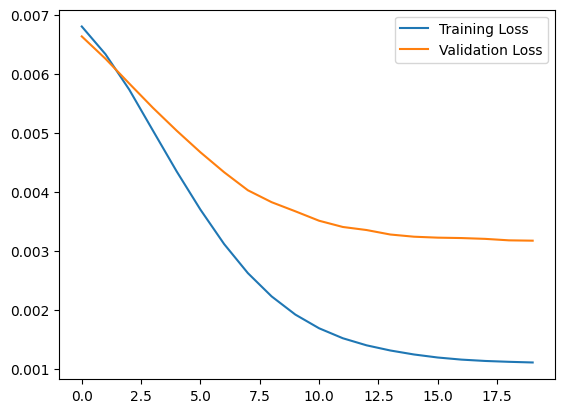

In [ ]:
plt.plot(history.history["loss"],label="Training Loss")
plt.plot(history.history["val_loss"],label="Validation Loss")
plt.legend()
plt.show()


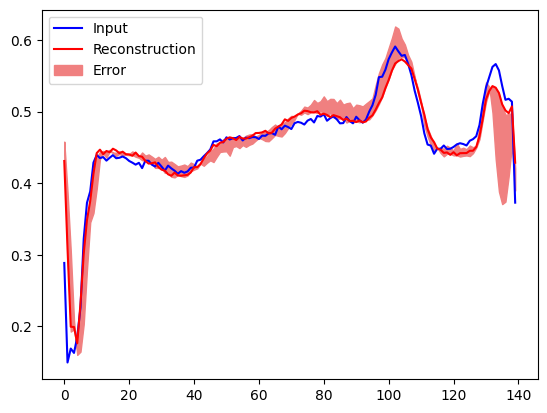

In [ ]:
encoded_data=autoencoder.encoder(normal_test_data).numpy()
decoded_data=autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[9],'b')
plt.plot(decoded_data[5],'r')
plt.fill_between(np.arange(140),decoded_data[0],normal_test_data[0],color="lightcoral")
plt.legend(labels=["Input","Reconstruction","Error"])
plt.show()

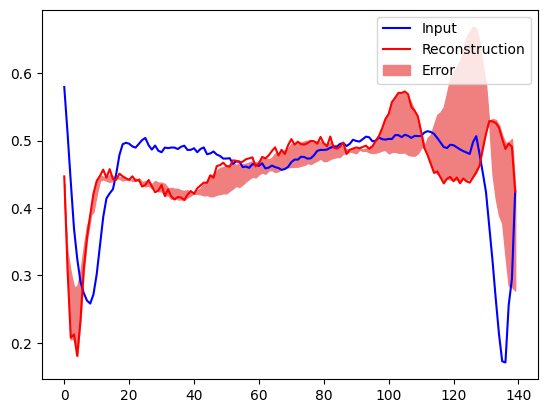

In [ ]:
encoded_data=autoencoder.encoder(anomalous_test_data).numpy()
decoded_data=autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[9],'b')
plt.plot(decoded_data[10],'r')
plt.fill_between(np.arange(140),decoded_data[0],anomalous_test_data[0],color="lightcoral")
plt.legend(labels=["Input","Reconstruction","Error"])
plt.show()

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
tf.Tensor(0.0005567351, shape=(), dtype=float32)


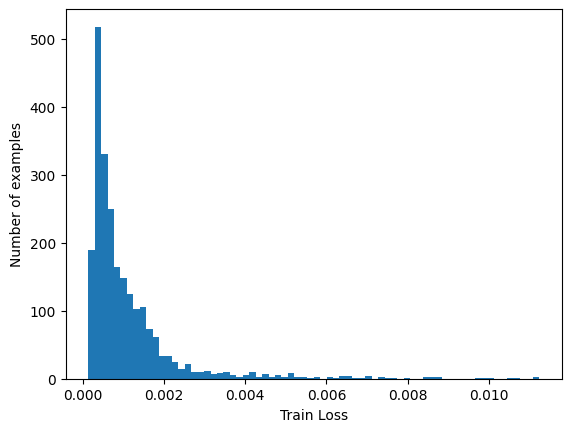

In [ ]:
# Predict on normal training data
reconstruction = autoencoder.predict(normal_train_data)

# Compute MSE loss for each sample
mse = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
train_loss = mse(normal_train_data, reconstruction)
print(train_loss[70])
# Convert the loss to a NumPy array
train_loss_np = train_loss.numpy()

# Plot histogram
plt.hist(train_loss_np, bins=70)
plt.xlabel("Train Loss")
plt.ylabel("Number of examples")
plt.show()


In [ ]:
threshold=np.mean(train_loss) + np.std(train_loss)
print("Threshold:" ,threshold)

Threshold: 0.0023300697


In [ ]:
print(normal_train_data.shape)
print(reconstruction.shape)


(2354, 140)
(2354, 140)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
tf.Tensor(0.007005686, shape=(), dtype=float32)


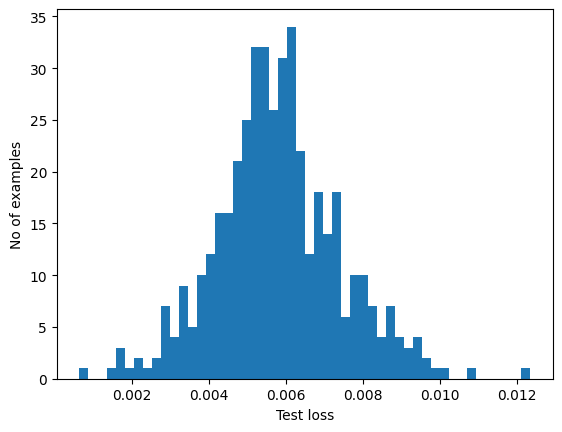

In [ ]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = mse(reconstructions, anomalous_test_data)
print(test_loss[9])
plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mse(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [ ]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.941
Precision = 0.982791586998088
Recall = 0.9113475177304965
